In [1]:
!mkdir %userprofile%\.kaggle
!copy kaggle.json %userprofile%\.kaggle\

A subdirectory or file C:\Users\001\.kaggle already exists.


        1 file(s) copied.


In [ ]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition/notebook

https://www.kaggle.com/code/mostafaabdlhamed/speech-emotion-recognition-97-25-accuracy

https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb

# Imports

In [221]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from IPython.display import Audio

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, BatchNormalization, Conv2D,MaxPooling2D, AveragePooling1D
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.optimizers import SGD

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200

In [3]:
Ravdess = "./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/"
Crema = "./speech-emotion-recognition-en/Crema/"
Tess = "./speech-emotion-recognition-en/Tess/"
Savee = "./speech-emotion-recognition-en/Savee/"

# Ravdess Dataset

In [4]:
file_paths_ravdess = []
file_emotions_ravdess = []
actors = os.listdir(Ravdess)
for actor in actors:
    files = os.listdir(Ravdess+actor)
    for file in files:
        file_part = file.split('.')
        file_part_2 = file_part[0].split('-')
        emotion = int(file_part_2[2])
        file_emotions_ravdess.append(emotion)
        file_paths_ravdess.append(Ravdess+actor+'/'+file)
ravdess_df = pd.DataFrame(zip(file_emotions_ravdess,file_paths_ravdess),columns=['Emotions','Paths'])
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head()

Emotions  \
0  neutral   
1  neutral   
2  neutral   
3  neutral   
4     calm   

                                                                                                 Paths  
0  ./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav  
1  ./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav  
2  ./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-01-01.wav  
3  ./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-02-01.wav  
4  ./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01-01.wav

# Crema Dataset

In [5]:
files = os.listdir(Crema)
file_paths_crema = []
file_emotions_crema = []
for file in files:
    file_part = file.split('.')
    file_part_2 = file_part[0].split('_')
    emotion = file_part_2[2]
    if emotion == 'SAD':
        file_emotions_crema.append('sad')
    elif emotion == 'ANG':
        file_emotions_crema.append('angry')
    elif emotion == 'DIS':
        file_emotions_crema.append('disgust')
    elif emotion == 'FEA':
        file_emotions_crema.append('fear')
    elif emotion == 'HAP':
        file_emotions_crema.append('happy')
    elif emotion == 'NEU':
        file_emotions_crema.append('neutral')
    else:
        file_emotions_crema.append('Unknown')
    file_paths_crema.append(Crema+file)

crema_df = pd.DataFrame(zip(file_emotions_crema,file_paths_crema),columns=['Emotions','Paths'])
crema_df.head()

Emotions                                                      Paths
0    angry  ./speech-emotion-recognition-en/Crema/1001_DFA_ANG_XX.wav
1  disgust  ./speech-emotion-recognition-en/Crema/1001_DFA_DIS_XX.wav
2     fear  ./speech-emotion-recognition-en/Crema/1001_DFA_FEA_XX.wav
3    happy  ./speech-emotion-recognition-en/Crema/1001_DFA_HAP_XX.wav
4  neutral  ./speech-emotion-recognition-en/Crema/1001_DFA_NEU_XX.wav

# Tess Dataset

In [6]:
file_paths_tess = []
file_emotions_tess = []
dirs = os.listdir(Tess)
for d in dirs:
    files = os.listdir(Tess+d)
    emotion_from_dir = d.split('_')[-1].lower()
    emotion_from_dir = 'surprise' if emotion_from_dir=='surprised' else emotion_from_dir # because there is a folder named YAF_pleasant_surprised
    file_emotions_tess+=[emotion_from_dir]*len(files)
    for file in files:
        file_paths_tess.append(Tess+d+'/'+file)
tess_df = pd.DataFrame(zip(file_emotions_tess,file_paths_tess),columns=['Emotions','Paths'])

In [7]:
tess_df.sample(10)

Emotions  \
1395      sad   
880   neutral   
105     angry   
513      fear   
2360  neutral   
2389  neutral   
1251      sad   
836   neutral   
747     happy   
1662  disgust   

                                                                       Paths  
1395          ./speech-emotion-recognition-en/Tess/OAF_Sad/OAF_witch_sad.wav  
880    ./speech-emotion-recognition-en/Tess/OAF_neutral/OAF_laud_neutral.wav  
105        ./speech-emotion-recognition-en/Tess/OAF_angry/OAF_moon_angry.wav  
513          ./speech-emotion-recognition-en/Tess/OAF_Fear/OAF_note_fear.wav  
2360  ./speech-emotion-recognition-en/Tess/YAF_neutral/YAF_south_neutral.wav  
2389   ./speech-emotion-recognition-en/Tess/YAF_neutral/YAF_when_neutral.wav  
1251           ./speech-emotion-recognition-en/Tess/OAF_Sad/OAF_good_sad.wav  
836    ./speech-emotion-recognition-en/Tess/OAF_neutral/OAF_fail_neutral.wav  
747       ./speech-emotion-recognition-en/Tess/OAF_happy/OAF_seize_happy.wav  
1662   ./speech-emotion-recognition-en/Tess/YAF_disgust/YAF_hole_disgust.wav

# Savee Dataset

In [8]:
savee_directory_list = os.listdir(Savee)

file_emotions_savee = []
file_paths_savee = []

for file in savee_directory_list:
    file_paths_savee.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotions_savee.append('angry')
    elif ele=='d':
        file_emotions_savee.append('disgust')
    elif ele=='f':
        file_emotions_savee.append('fear')
    elif ele=='h':
        file_emotions_savee.append('happy')
    elif ele=='n':
        file_emotions_savee.append('neutral')
    elif ele=='sa':
        file_emotions_savee.append('sad')
    else:
        file_emotions_savee.append('surprise')
        
savee_df = pd.DataFrame(zip(file_emotions_savee,file_paths_savee), columns=['Emotions','Paths'])

In [9]:
savee_df.sample(10)

Emotions                                              Paths
445  neutral   ./speech-emotion-recognition-en/Savee/KL_n26.wav
192  neutral   ./speech-emotion-recognition-en/Savee/JE_n13.wav
143  disgust   ./speech-emotion-recognition-en/Savee/JE_d09.wav
453      sad  ./speech-emotion-recognition-en/Savee/KL_sa04.wav
99       sad  ./speech-emotion-recognition-en/Savee/DC_sa10.wav
319  neutral   ./speech-emotion-recognition-en/Savee/JK_n20.wav
402     fear   ./speech-emotion-recognition-en/Savee/KL_f13.wav
76   neutral   ./speech-emotion-recognition-en/Savee/DC_n17.wav
253    angry   ./speech-emotion-recognition-en/Savee/JK_a14.wav
263  disgust   ./speech-emotion-recognition-en/Savee/JK_d09.wav

# Concatenate whole dataframes

In [10]:
data_df = pd.concat([ravdess_df,crema_df,tess_df,savee_df],axis=0)

In [11]:
data_df.sample(10)

Emotions  \
4648       sad   
4851   neutral   
436        sad   
1171  surprise   
2432  surprise   
242      angry   
1844   disgust   
551       calm   
3459     angry   
651    disgust   

                                                                                                    Paths  
4648                                            ./speech-emotion-recognition-en/Crema/1057_TSI_SAD_XX.wav  
4851                                            ./speech-emotion-recognition-en/Crema/1060_ITH_NEU_XX.wav  
436                                             ./speech-emotion-recognition-en/Crema/1006_IOM_SAD_XX.wav  
1171                        ./speech-emotion-recognition-en/Tess/OAF_Pleasant_surprise/OAF_thought_ps.wav  
2432                         ./speech-emotion-recognition-en/Tess/YAF_pleasant_surprised/YAF_ditch_ps.wav  
242                                                      ./speech-emotion-recognition-en/Savee/JK_a03.wav  
1844                                            ./speech-emotion-recognition-en/Crema/1023_TAI_DIS_XX.wav  
551   ./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_10/03-01-02-02-02-02-10.wav  
3459                                            ./speech-emotion-recognition-en/Crema/1043_ITS_ANG_XX.wav  
651   ./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_11/03-01-07-02-02-02-11.wav

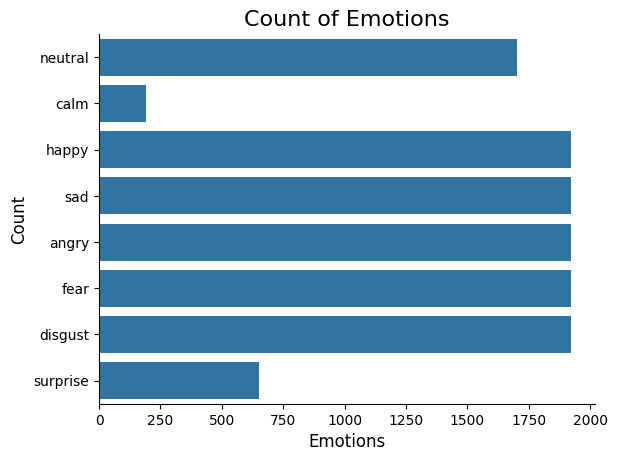

In [12]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Try out some audio files

## Using Librosa

In [13]:
def get_random_sample():
    random_sample = data_df.iloc[np.random.randint(len(data_df))]
    return random_sample.Emotions, random_sample.Paths

In [14]:
temp_audio_emotion,temp_audio_path = get_random_sample()

In [15]:
temp_audio_emotion

'happy'

In [16]:
Audio(temp_audio_path)

In [17]:
raw_data, sample_rate = librosa.load(temp_audio_path)

In [18]:
raw_data, sample_rate

(array([-2.1176573e-03, -1.6344736e-03, -8.0644729e-04, ...,
        -3.3251714e-11, -3.0017908e-11,  0.0000000e+00], dtype=float32),
 22050)

In [19]:
raw_data.shape

(44145,)

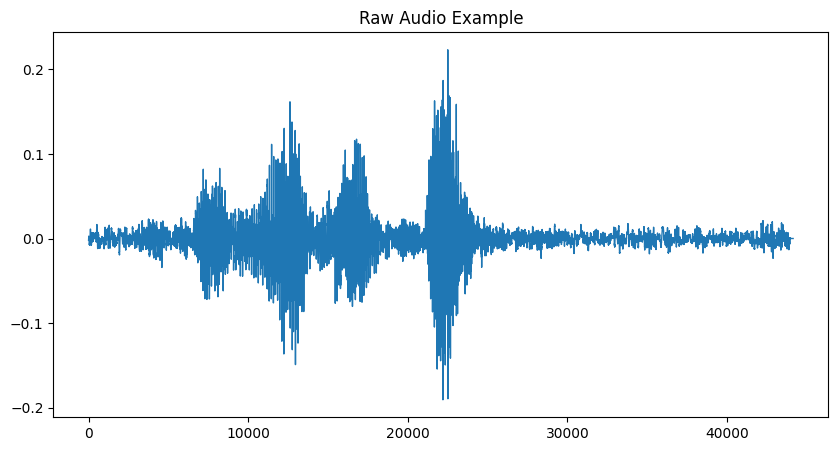

In [20]:
pd.Series(raw_data).plot(figsize=(10,5),lw=1,title='Raw Audio Example')
plt.show()

As you can notice there are alot of silence at the beginning and the end of the audio file.

In [21]:
raw_data_trimmed, index = librosa.effects.trim(raw_data,top_db=20)

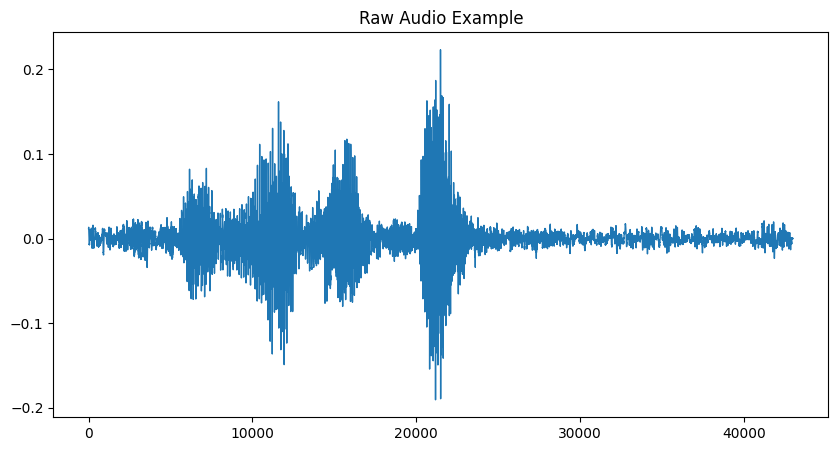

In [22]:
pd.Series(raw_data_trimmed).plot(figsize=(10,5),lw=1,title='Raw Audio Example')
plt.show()

In [72]:
def create_waveplot(data, e):
    pd.Series(data).plot(figsize=(10,5),lw=1,title=f'{e} emotion')
    plt.show()

def create_spectogram(data, sr, e=None, plot=True):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    if plot:
        plt.figure(figsize=(12, 3))
        plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
        plt.colorbar()
    return Xdb

def create_mel_spectogram(data,sr,e=None, plot=True):
    S = librosa.feature.melspectrogram(y=data,sr=sr,n_mels=128 * 2)
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
    if plot:
        fig, ax = plt.subplots(figsize=(10, 5))
        img = librosa.display.specshow(S_db_mel,x_axis='time',y_axis='log',ax=ax)
        ax.set_title('Mel Spectogram Example', fontsize=20)
        fig.colorbar(img, ax=ax, format=f'%0.2f')
        plt.show()
    return S_db_mel

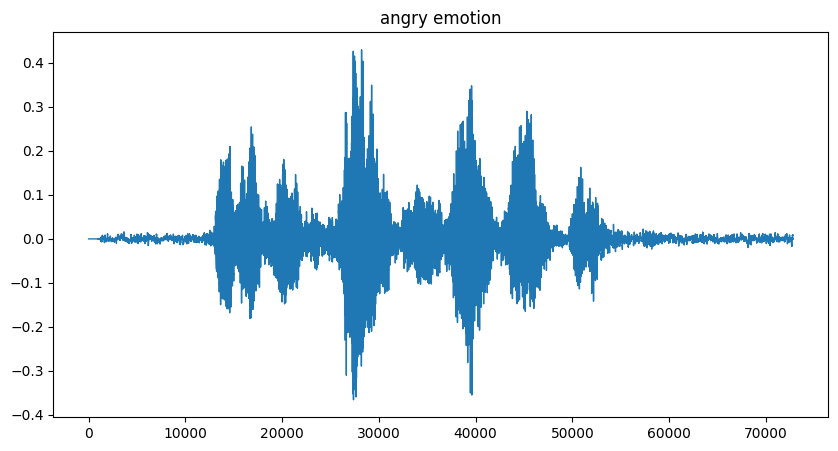

In [73]:
random_sample_emotion,random_sample_path = get_random_sample()
random_sample_data,random_sample_sr = librosa.load(random_sample_path, sr=32000) 
create_waveplot(random_sample_data,random_sample_emotion)

In [74]:
random_sample_data.shape,random_sample_sr

((72818,), 32000)

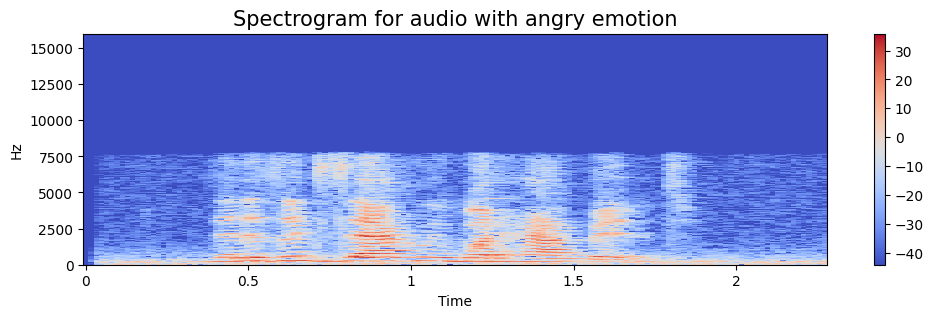

In [75]:
spectogram = create_spectogram(random_sample_data, 32000, random_sample_emotion)

In [76]:
spectogram.shape

(1025, 143)

In [77]:
tf.expand_dims(spectogram, axis=2)

<tf.Tensor: shape=(1025, 143, 1), dtype=float32, numpy=
array([[[-44.180233 ],
        [-41.523685 ],
        [-19.976934 ],
        ...,
        [ -8.35018  ],
        [-17.320759 ],
        [ -3.8420196]],

       [[-44.180233 ],
        [-40.598965 ],
        [-18.123688 ],
        ...,
        [-16.375257 ],
        [ -4.0228148],
        [ -1.7305   ]],

       [[-44.180233 ],
        [-38.863968 ],
        [-14.886121 ],
        ...,
        [ -2.3039699],
        [ -0.2909302],
        [ -1.0666622]],

       ...,

       [[-44.180233 ],
        [-44.180233 ],
        [-44.180233 ],
        ...,
        [-44.180233 ],
        [-44.180233 ],
        [-44.180233 ]],

       [[-44.180233 ],
        [-44.180233 ],
        [-44.180233 ],
        ...,
        [-44.180233 ],
        [-44.180233 ],
        [-44.180233 ]],

       [[-44.180233 ],
        [-44.180233 ],
        [-44.180233 ],
        ...,
        [-44.180233 ],
        [-44.180233 ],
        [-44.180233 ]]], dtype=float32

In [78]:
Audio(random_sample_path)

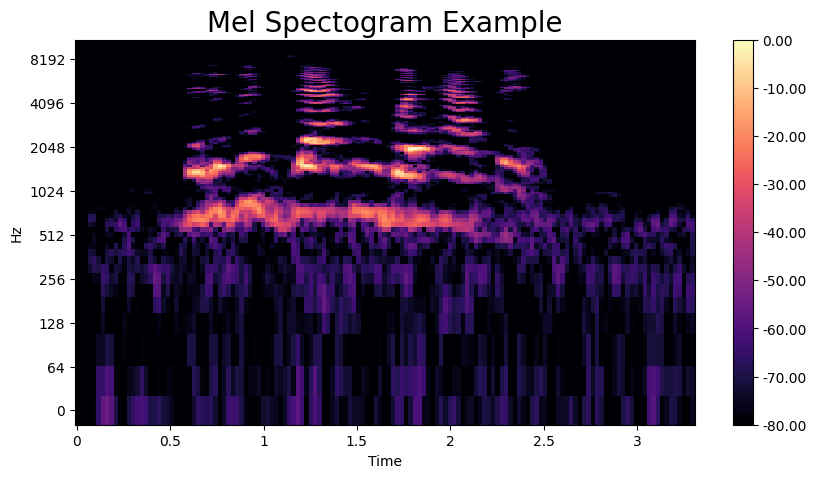

In [79]:
mel_spectogram=create_mel_spectogram(random_sample_data, 32000, random_sample_emotion)

In [80]:
mel_spectogram.shape

(256, 143)

In [81]:
tf.math.reduce_max(mel_spectogram)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

# Lets's view the wave plot and mel spectogram of every emotion

In [82]:
data_df[data_df['Emotions']=='angry'].sample()['Paths'].values[0]

'./speech-emotion-recognition-en/Tess/YAF_angry/YAF_when_angry.wav'

In [87]:
def view_emotion(df,emotion):
    row = df[df['Emotions']==emotion].sample()
    row_path = row['Paths'].values[0]
    ipd.display(Audio(row_path))
    random_sample_data,random_sample_sr = librosa.load(row_path, sr=32000) 
    create_waveplot(random_sample_data,emotion)
    create_spectogram(random_sample_data,random_sample_sr)
    create_mel_spectogram(random_sample_data,random_sample_sr)

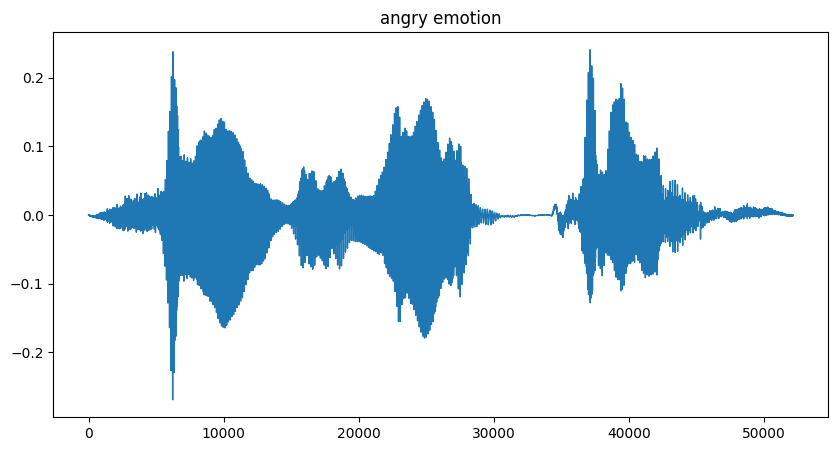

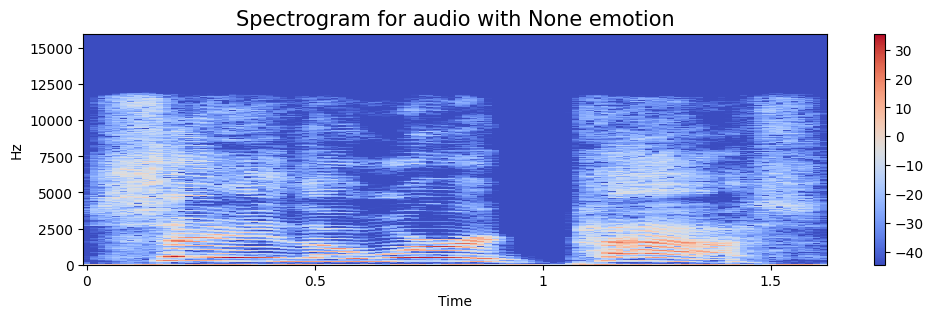

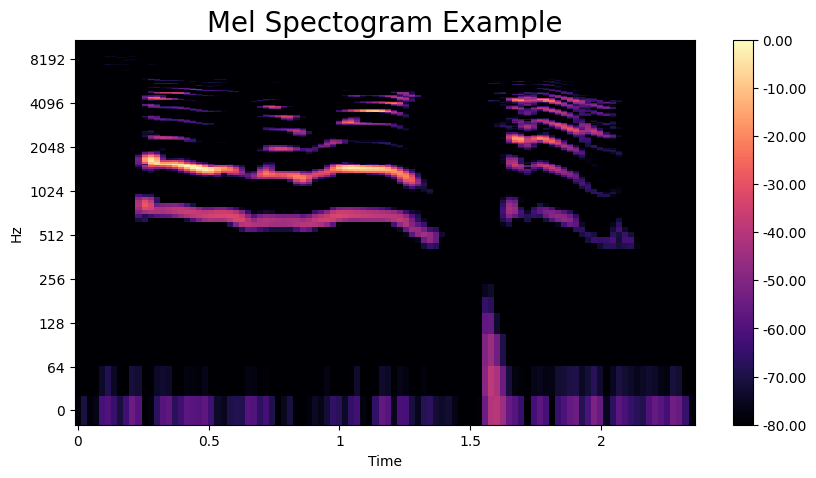

In [88]:
view_emotion(data_df,'angry')

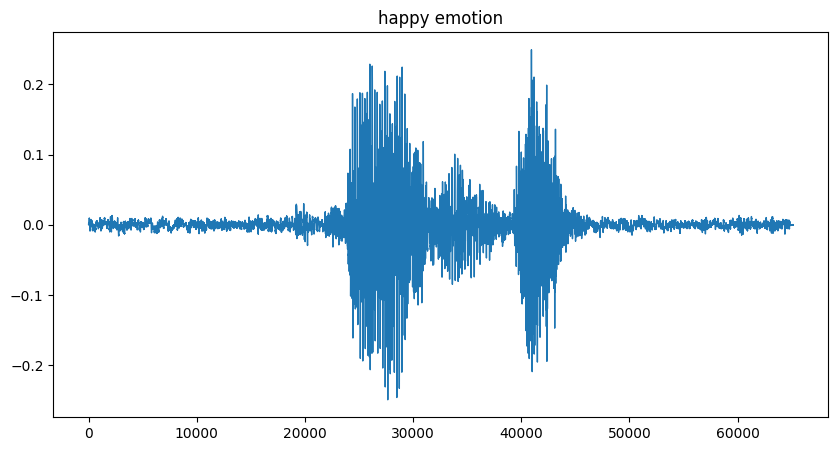

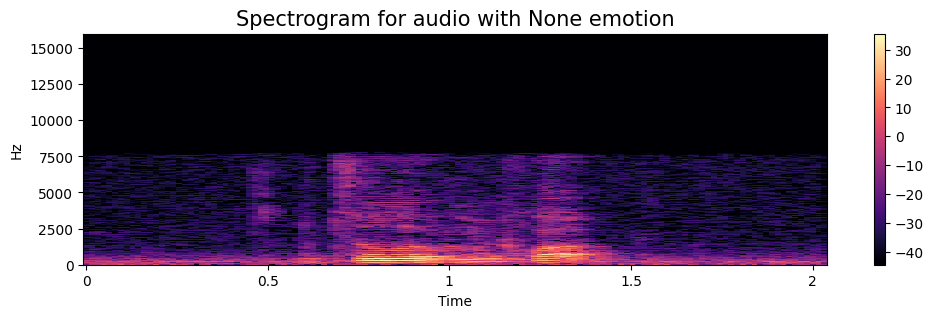

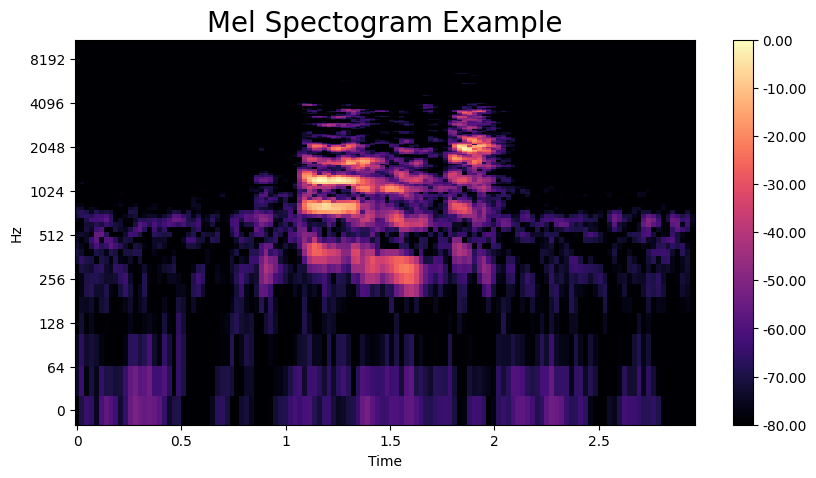

In [89]:
view_emotion(data_df,'happy')

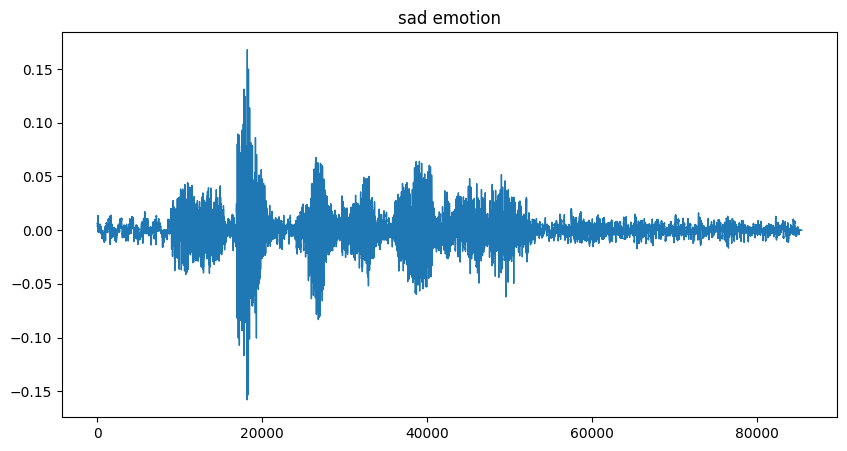

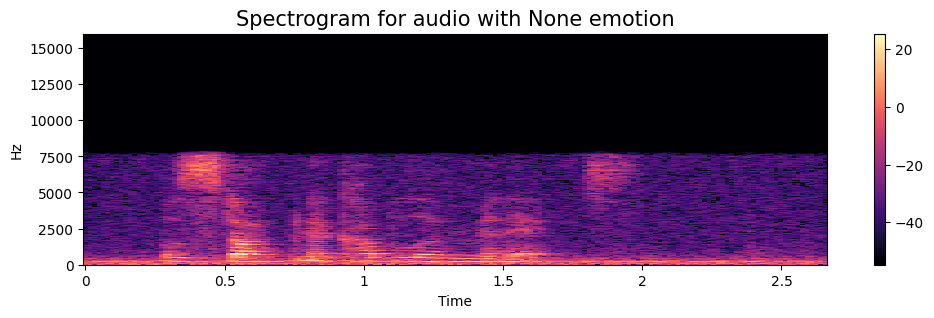

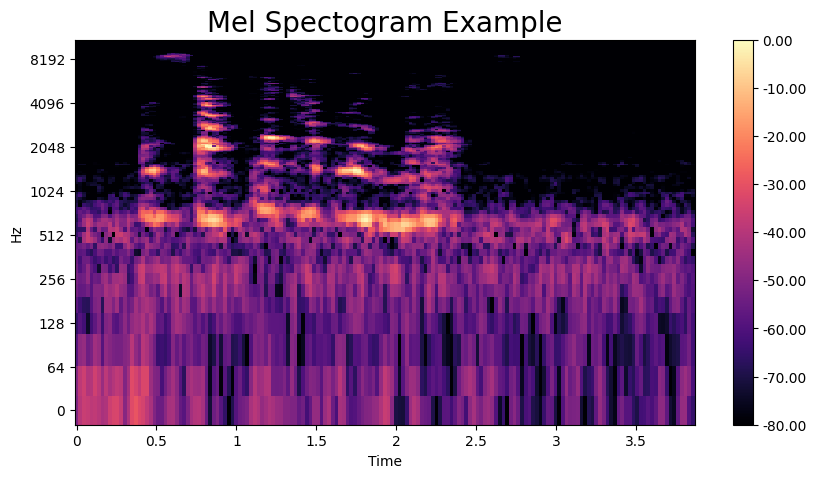

In [90]:
view_emotion(data_df,'sad')

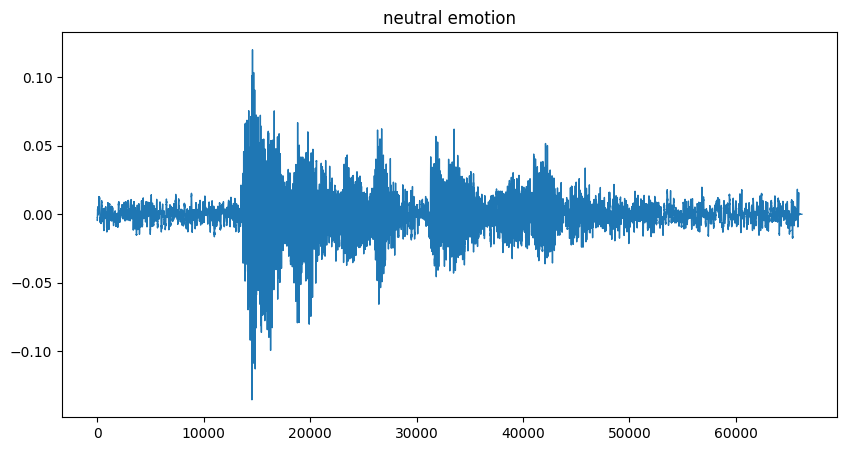

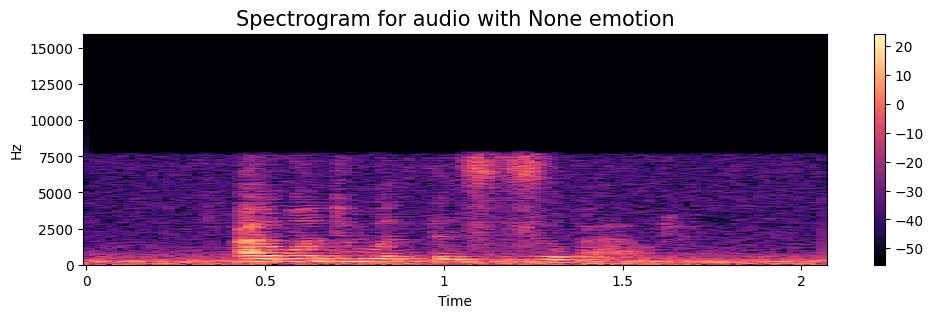

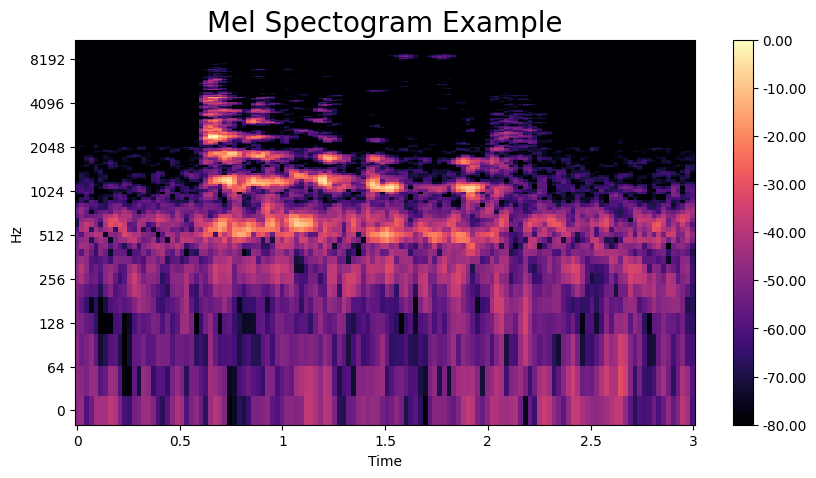

In [91]:
view_emotion(data_df,'neutral')

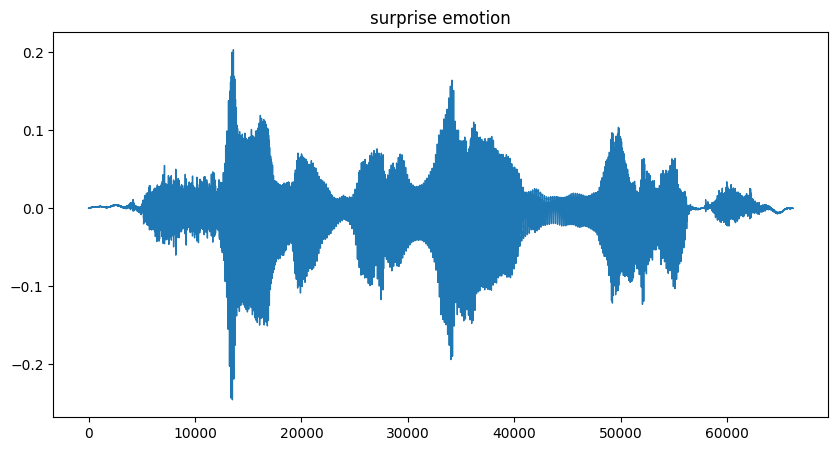

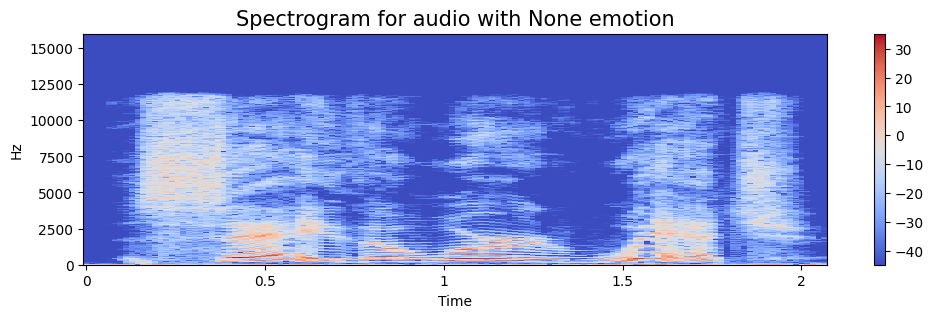

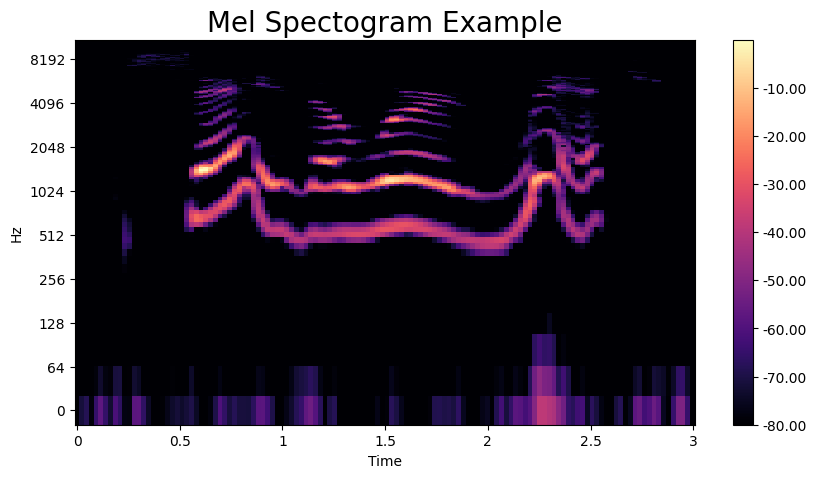

In [92]:
view_emotion(data_df,'surprise')

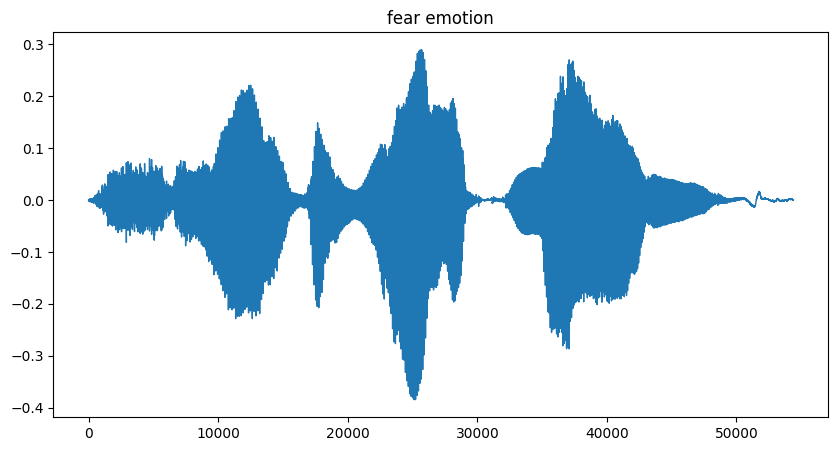

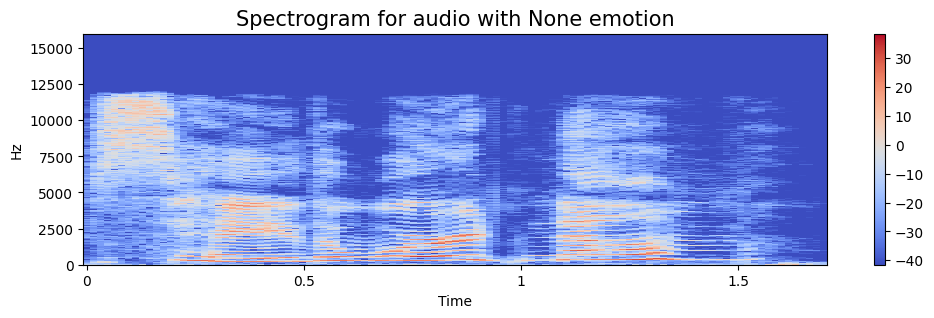

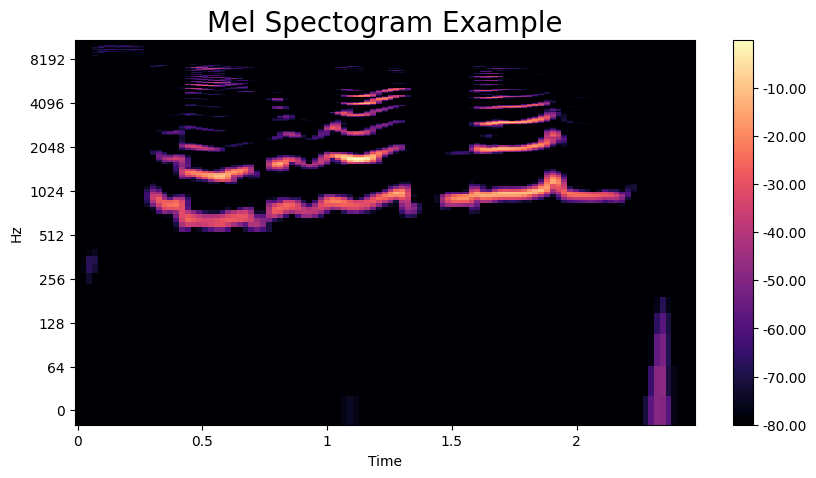

In [93]:
view_emotion(data_df,'fear')

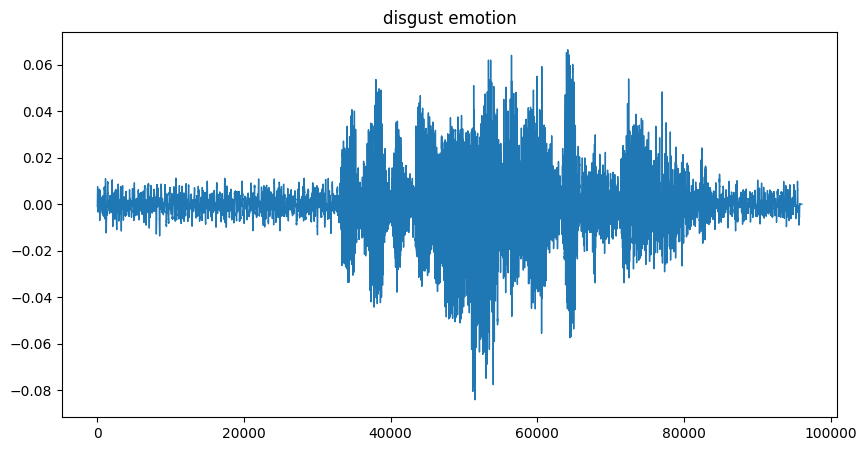

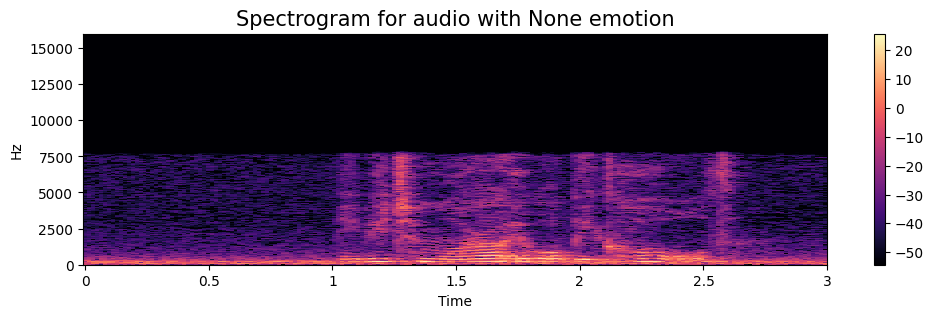

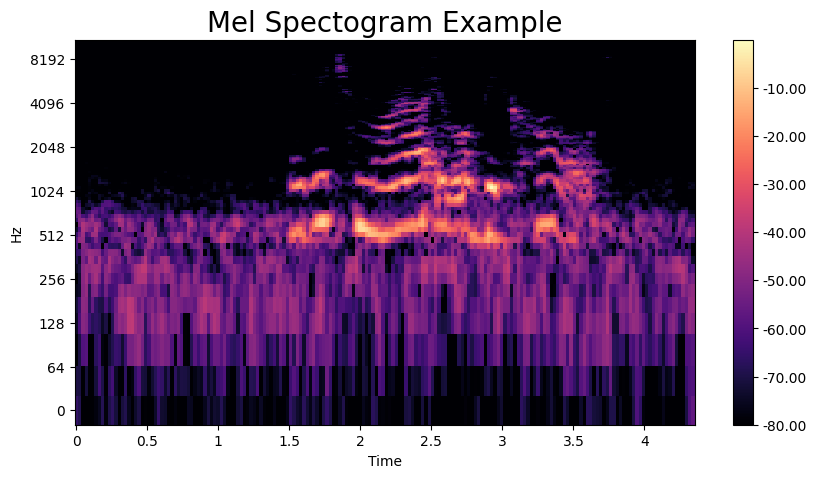

In [94]:
view_emotion(data_df,'disgust')

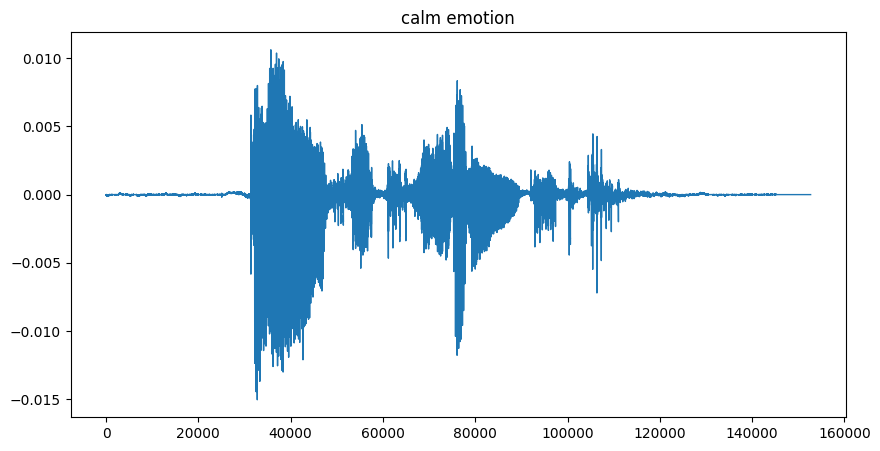

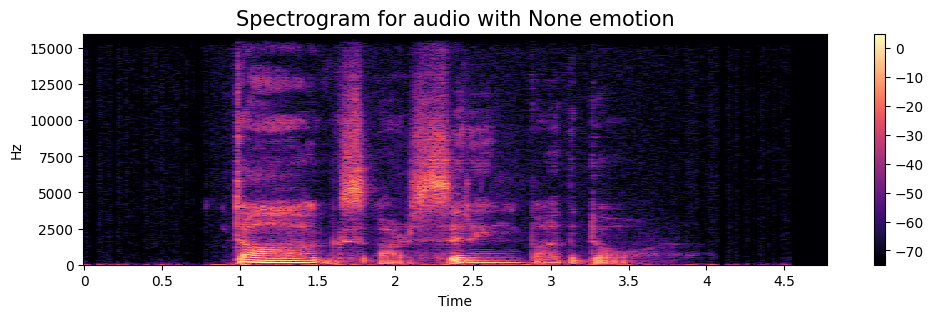

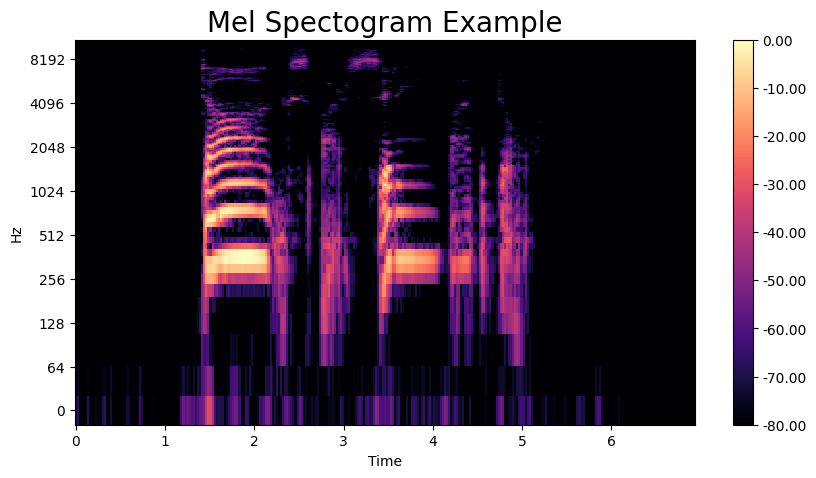

In [95]:
view_emotion(data_df,'calm')

In [96]:
lengths=[]
for row in data_df.iterrows():
    data,sr = librosa.load(row[1]['Paths'])
    lengths.append(len(data))

In [97]:
lengths = np.array(lengths)

In [98]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=57746>

In [99]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=157409>

In [100]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=27653>

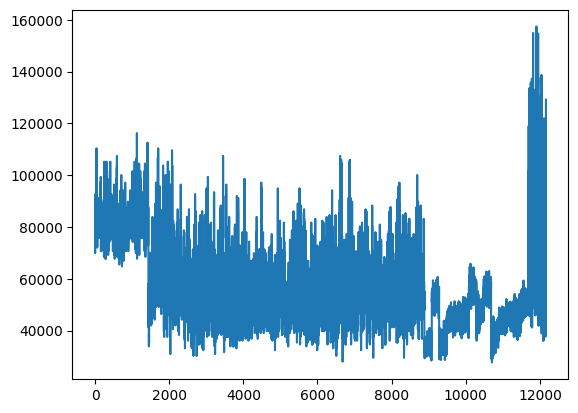

In [101]:
plt.plot(lengths)
plt.show()

In [102]:
lengths = np.sort(lengths)

In [103]:
fixed_size = lengths[int(0.85*len(lengths))]
fixed_size

75781

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(data_df.Paths.values, data_df.Emotions.values, test_size=0.2, random_state=42, shuffle=True)

In [105]:
len(X_train)

9729

In [106]:
valid_ratio = int(0.5*len(X_valid)) 
X_val, X_test = X_valid[:valid_ratio], X_valid[valid_ratio:]
y_val, y_test = y_valid[:valid_ratio], y_valid[valid_ratio:]

In [107]:
len(X_val),len(X_test)

(1216, 1217)

In [108]:
unique_emotions= data_df.Emotions.unique()
unique_emotions

array(['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust',
       'surprise'], dtype=object)

In [109]:
emotion_to_index = {emotion: index for index, emotion in enumerate(unique_emotions)}
emotion_to_index

{'neutral': 0,
 'calm': 1,
 'happy': 2,
 'sad': 3,
 'angry': 4,
 'fear': 5,
 'disgust': 6,
 'surprise': 7}

In [110]:
label_idx = emotion_to_index['angry']
new_label = tf.one_hot(label_idx,depth = len(unique_emotions))
new_label

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>

In [111]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
input_shape = (256, 149, 1)

In [144]:
def preprocess_data(file_path,label):
    raw_data, sr = librosa.load(file_path)
    raw_data = raw_data[:fixed_size]
    zero_padding = tf.zeros([fixed_size] - tf.shape(raw_data), dtype=tf.float32)
    raw_data = tf.concat([zero_padding, raw_data],0)
    mel_spectogram = create_mel_spectogram(np.array(raw_data),sr,plot=False)
    mel_spectogram = tf.expand_dims(mel_spectogram, axis=2)
    mel_spectogram /= (tf.math.reduce_max(mel_spectogram)+1e-6)
    label_idx = emotion_to_index[label]
    new_label = tf.one_hot(label_idx,depth = len(unique_emotions))
    return mel_spectogram, new_label

In [145]:
def preprocess(X,y):
    mel_sps = []
    labels = []
    for file_path,label in zip(X,y):
        mel_sp, new_label = preprocess_data(file_path,label)
        mel_sps.append(mel_sp)
        labels.append(new_label)
    return np.array(mel_sps), np.array(labels)

In [146]:
mel_sps_train, new_labels_train = preprocess(X_train,y_train)

In [147]:
mel_sps_train.shape, new_labels_train.shape

((9729, 256, 149, 1), (9729, 8))

In [148]:
mel_sps_val, new_labels_val = preprocess(X_val,y_val)
mel_sps_test, new_labels_test = preprocess(X_test,y_test)

In [149]:
train_ds = tf.data.Dataset.from_tensor_slices((mel_sps_train,new_labels_train))
val_ds = tf.data.Dataset.from_tensor_slices((mel_sps_val,new_labels_val))
test_ds = tf.data.Dataset.from_tensor_slices((mel_sps_test,new_labels_test))

In [150]:
for x in train_ds:
    print(x[0].shape)
    print(tf.math.reduce_max(x[0]))
    break

(256, 149, 1)
tf.Tensor(0.79230267, shape=(), dtype=float32)


In [151]:
train_ds = train_ds.cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(AUTOTUNE)

# Build Model

In [152]:
model=Sequential()
model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))

In [153]:
model.compile('Adam', loss='categorical_crossentropy', metrics=[Recall(),Precision(), 'accuracy'])

In [154]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 149, 256)     6656      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 128, 75, 256)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 75, 256)      1638656   
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 38, 256)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 38, 128)       819328    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 19, 128)     

In [155]:
hist = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
305/305 [==============================] - 58s 189ms/step - loss: 540429.7500 - recall_4: 0.0043 - precision_4: 0.1102 - accuracy: 0.1585 - val_loss: 2.0295 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - val_accuracy: 0.1488
Epoch 2/20
305/305 [==============================] - 58s 190ms/step - loss: 2.0156 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - accuracy: 0.1592 - val_loss: 1.9978 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - val_accuracy: 0.1488
Epoch 3/20
 62/305 [=====>........................] - ETA: 44s - loss: 2.0032 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - accuracy: 0.1542

KeyboardInterrupt: 

# Data Augmentation

In [167]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

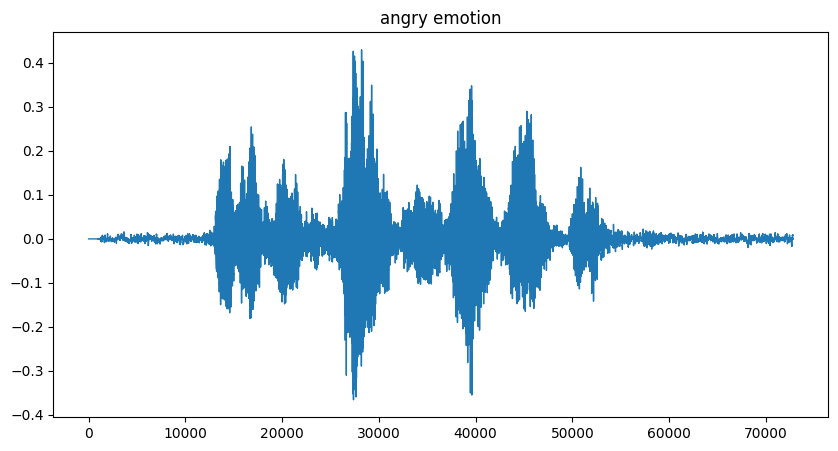

In [175]:
create_waveplot(random_sample_data,random_sample_emotion)
Audio(random_sample_data,rate=sr)

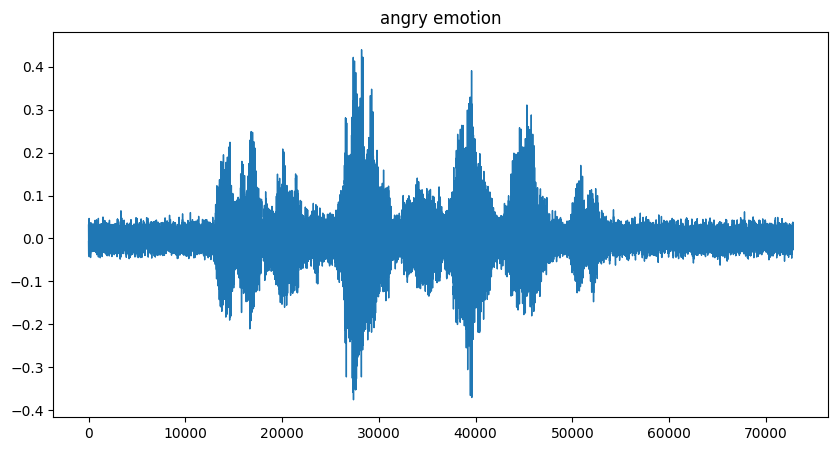

In [178]:
x_noise = noise(random_sample_data)
create_waveplot(x_noise,random_sample_emotion)
Audio(x_noise,rate=sr)

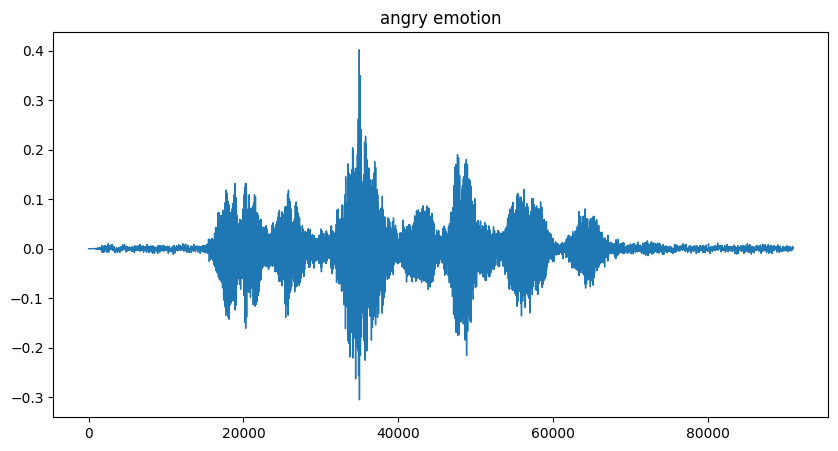

In [177]:
x_stretch = stretch(random_sample_data)
create_waveplot(x_stretch,random_sample_emotion)
Audio(x_stretch,rate=sr)

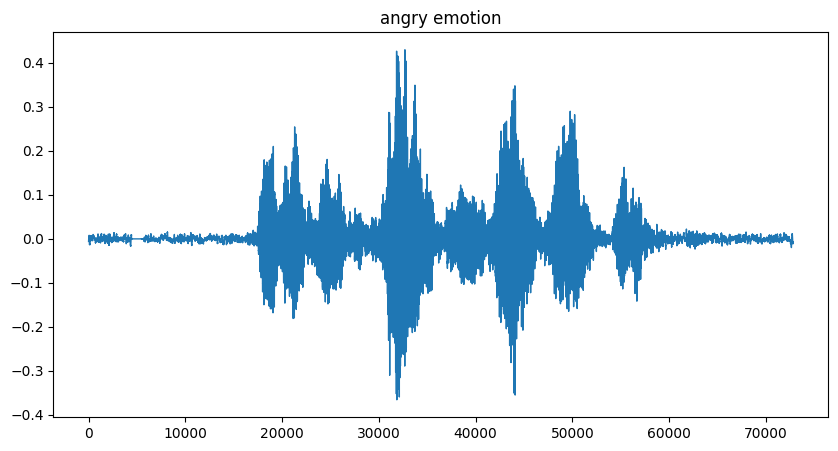

In [176]:
x_shift = shift(random_sample_data)
create_waveplot(x_shift,random_sample_emotion)
Audio(x_shift,rate=sr)

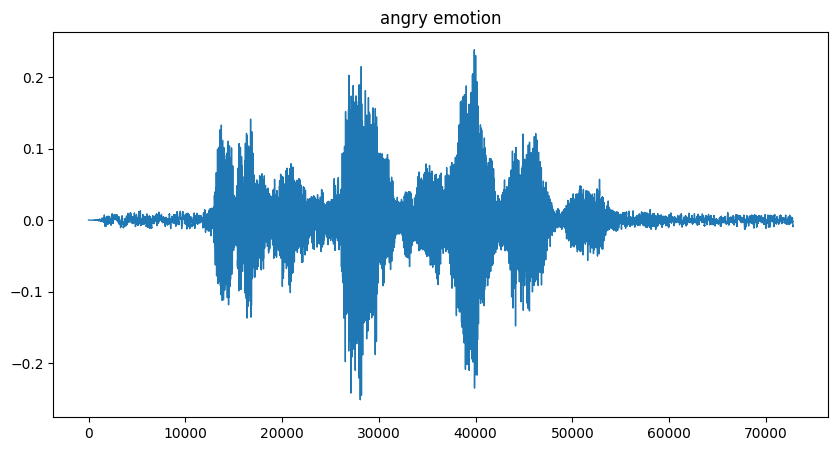

In [174]:
x_pitch = pitch(random_sample_data,sr)
create_waveplot(x_pitch,random_sample_emotion)
Audio(x_pitch,rate=sr)

# Feature Extraction

In [185]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio

In [187]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X_new,Y_new=[],[]
for path,emotion,index in tqdm (zip(data_df.Paths,data_df.Emotions,range(data_df.Paths.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X_new.append(i)
        Y_new.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

3it [00:00, 21.12it/s]

0 audio has been processed


504it [00:30, 16.11it/s]

500 audio has been processed


1002it [01:01, 16.78it/s]

1000 audio has been processed


1505it [01:31, 22.43it/s]

1500 audio has been processed


2003it [01:58, 20.21it/s]

2000 audio has been processed


2504it [02:25, 19.61it/s]

2500 audio has been processed


3005it [02:48, 18.37it/s]

3000 audio has been processed


3502it [03:13, 21.38it/s]

3500 audio has been processed


4002it [03:38, 19.34it/s]

4000 audio has been processed


4503it [04:04, 20.14it/s]

4500 audio has been processed


5004it [04:31, 16.55it/s]

5000 audio has been processed


5503it [04:58, 14.14it/s]

5500 audio has been processed


6005it [05:24, 19.81it/s]

6000 audio has been processed


6502it [05:51, 18.52it/s]

6500 audio has been processed


7003it [06:19, 20.83it/s]

7000 audio has been processed


7503it [06:47, 15.25it/s]

7500 audio has been processed


8002it [07:18, 16.22it/s]

8000 audio has been processed


8503it [07:48, 14.26it/s]

8500 audio has been processed


9003it [08:17, 25.27it/s]

9000 audio has been processed


9506it [08:41, 28.21it/s]

9500 audio has been processed


10005it [09:03, 21.01it/s]

10000 audio has been processed


10504it [09:30, 17.81it/s]

10500 audio has been processed


11004it [09:54, 22.84it/s]

11000 audio has been processed


11503it [10:19, 19.06it/s]

11500 audio has been processed


12003it [10:51, 11.38it/s]

12000 audio has been processed


12162it [11:02, 18.36it/s]

Done
Time:  662.548776599986


In [188]:
new_df = pd.DataFrame(X_new)
new_df['Emotions'] = Y_new
new_df.to_csv('emotions.csv', index=False)
new_df.head()

0         1         2         3         4         5         6  \
0  0.173828  0.264648  0.372559  0.486328  0.625488  0.681152  0.720703   
1  0.268555  0.395020  0.520508  0.518555  0.502930  0.500488  0.493652   
2  0.256348  0.354492  0.471191  0.414062  0.378418  0.373535  0.354492   
3  0.258301  0.385254  0.514160  0.513672  0.506348  0.498047  0.490723   
4  0.247070  0.389648  0.564941  0.642578  0.665527  0.684570  0.676270   

          7         8         9        10        11        12        13  \
0  0.651855  0.562988  0.559082  0.559570  0.567383  0.541016  0.520020   
1  0.490723  0.498047  0.501465  0.519531  0.503418  0.488770  0.485840   
2  0.408691  0.466797  0.522461  0.580566  0.585938  0.562500  0.483398   
3  0.484863  0.491211  0.498047  0.520020  0.525391  0.525391  0.518555   
4  0.666992  0.648926  0.595703  0.528320  0.496582  0.450195  0.521484   

         14        15        16        17        18        19        20  \
0  0.437012  0.421387  0.372070  0.341309  0.308594  0.203613  0.149414   
1  0.478027  0.489258  0.469727  0.449707  0.355957  0.245117  0.168945   
2  0.415527  0.346191  0.292969  0.277344  0.201660  0.143066  0.105469   
3  0.486816  0.481445  0.437988  0.379883  0.283203  0.177246  0.115234   
4  0.551758  0.553223  0.497559  0.396484  0.350586  0.247559  0.180664   

         21        22        23        24        25        26        27  \
0  0.071777  0.047363  0.083984  0.152832  0.169434  0.185059  0.159180   
1  0.075684  0.053223  0.096191  0.164551  0.183105  0.196777  0.163574   
2  0.062988  0.073730  0.136719  0.197266  0.238770  0.252930  0.198242   
3  0.073730  0.085449  0.149414  0.210938  0.256348  0.270508  0.218750   
4  0.107910  0.033203  0.034668  0.081543  0.165527  0.184082  0.187012   

         28        29        30        31        32        33        34  \
0  0.090820  0.073730  0.141113  0.195801  0.223145  0.224121  0.145020   
1  0.113281  0.130371  0.205078  0.259277  0.283203  0.261230  0.172363   
2  0.145996  0.137695  0.185059  0.222656  0.210938  0.180176  0.114258   
3  0.174316  0.173828  0.219238  0.268066  0.267578  0.221191  0.152344   
4  0.145996  0.071289  0.055176  0.049805  0.134277  0.186035  0.210938   

         35        36        37        38        39        40        41  \
0  0.081055  0.057129  0.062988  0.067871  0.077637  0.098145  0.091309   
1  0.108398  0.069336  0.068848  0.094238  0.132324  0.189941  0.180176   
2  0.068848  0.066895  0.070801  0.071289  0.083496  0.072754  0.072754   
3  0.092285  0.072754  0.079590  0.092773  0.137695  0.144043  0.156738   
4  0.208496  0.127930  0.072754  0.054688  0.064453  0.063477  0.083496   

         42        43        44        45        46        47        48  \
0  0.081543  0.067383  0.033691  0.028320  0.025879  0.027344  0.032227   
1  0.151855  0.114258  0.043457  0.038086  0.038574  0.047852  0.054688   
2  0.067871  0.052246  0.049805  0.041016  0.035645  0.040527  0.045410   
3  0.148926  0.105469  0.093750  0.082031  0.075684  0.079590  0.079590   
4  0.113281  0.104492  0.096191  0.068359  0.026855  0.025879  0.021973   

         49        50        51        52        53        54        55  \
0  0.041504  0.045898  0.047852  0.049805  0.044922  0.042969  0.040039   
1  0.061035  0.062500  0.053223  0.070312  0.080078  0.088867  0.088379   
2  0.052734  0.057129  0.060547  0.060547  0.057129  0.060547  0.052734   
3  0.076172  0.072754  0.074219  0.091797  0.102051  0.118164  0.114258   
4  0.024414  0.029297  0.037109  0.042969  0.046387  0.048340  0.047363   

         56        57        58        59        60        61        62  \
0  0.035156  0.032227  0.036621  0.032715  0.036621  0.039062  0.037109   
1  0.082031  0.082520  0.086426  0.080566  0.070801  0.057129  0.044922   
2  0.059082  0.063965  0.057129  0.057617  0.049316  0.046387  0.049316   
3  0.116699  0.129395  0.118164  0.121094  0.107422  0.095215  0.092285   
4  0.044434  0.041504  0.03

In [191]:
new_df = pd.read_csv('./emotions.csv')
new_df.head()

0         1         2         3         4         5         6  \
0  0.173828  0.264648  0.372559  0.486328  0.625488  0.681152  0.720703   
1  0.268555  0.395020  0.520508  0.518555  0.502930  0.500488  0.493652   
2  0.256348  0.354492  0.471191  0.414062  0.378418  0.373535  0.354492   
3  0.258301  0.385254  0.514160  0.513672  0.506348  0.498047  0.490723   
4  0.247070  0.389648  0.564941  0.642578  0.665527  0.684570  0.676270   

          7         8         9        10        11        12        13  \
0  0.651855  0.562988  0.559082  0.559570  0.567383  0.541016  0.520020   
1  0.490723  0.498047  0.501465  0.519531  0.503418  0.488770  0.485840   
2  0.408691  0.466797  0.522461  0.580566  0.585938  0.562500  0.483398   
3  0.484863  0.491211  0.498047  0.520020  0.525391  0.525391  0.518555   
4  0.666992  0.648926  0.595703  0.528320  0.496582  0.450195  0.521484   

         14        15        16        17        18        19        20  \
0  0.437012  0.421387  0.372070  0.341309  0.308594  0.203613  0.149414   
1  0.478027  0.489258  0.469727  0.449707  0.355957  0.245117  0.168945   
2  0.415527  0.346191  0.292969  0.277344  0.201660  0.143066  0.105469   
3  0.486816  0.481445  0.437988  0.379883  0.283203  0.177246  0.115234   
4  0.551758  0.553223  0.497559  0.396484  0.350586  0.247559  0.180664   

         21        22        23        24        25        26        27  \
0  0.071777  0.047363  0.083984  0.152832  0.169434  0.185059  0.159180   
1  0.075684  0.053223  0.096191  0.164551  0.183105  0.196777  0.163574   
2  0.062988  0.073730  0.136719  0.197266  0.238770  0.252930  0.198242   
3  0.073730  0.085449  0.149414  0.210938  0.256348  0.270508  0.218750   
4  0.107910  0.033203  0.034668  0.081543  0.165527  0.184082  0.187012   

         28        29        30        31        32        33        34  \
0  0.090820  0.073730  0.141113  0.195801  0.223145  0.224121  0.145020   
1  0.113281  0.130371  0.205078  0.259277  0.283203  0.261230  0.172363   
2  0.145996  0.137695  0.185059  0.222656  0.210938  0.180176  0.114258   
3  0.174316  0.173828  0.219238  0.268066  0.267578  0.221191  0.152344   
4  0.145996  0.071289  0.055176  0.049805  0.134277  0.186035  0.210938   

         35        36        37        38        39        40        41  \
0  0.081055  0.057129  0.062988  0.067871  0.077637  0.098145  0.091309   
1  0.108398  0.069336  0.068848  0.094238  0.132324  0.189941  0.180176   
2  0.068848  0.066895  0.070801  0.071289  0.083496  0.072754  0.072754   
3  0.092285  0.072754  0.079590  0.092773  0.137695  0.144043  0.156738   
4  0.208496  0.127930  0.072754  0.054688  0.064453  0.063477  0.083496   

         42        43        44        45        46        47        48  \
0  0.081543  0.067383  0.033691  0.028320  0.025879  0.027344  0.032227   
1  0.151855  0.114258  0.043457  0.038086  0.038574  0.047852  0.054688   
2  0.067871  0.052246  0.049805  0.041016  0.035645  0.040527  0.045410   
3  0.148926  0.105469  0.093750  0.082031  0.075684  0.079590  0.079590   
4  0.113281  0.104492  0.096191  0.068359  0.026855  0.025879  0.021973   

         49        50        51        52        53        54        55  \
0  0.041504  0.045898  0.047852  0.049805  0.044922  0.042969  0.040039   
1  0.061035  0.062500  0.053223  0.070312  0.080078  0.088867  0.088379   
2  0.052734  0.057129  0.060547  0.060547  0.057129  0.060547  0.052734   
3  0.076172  0.072754  0.074219  0.091797  0.102051  0.118164  0.114258   
4  0.024414  0.029297  0.037109  0.042969  0.046387  0.048340  0.047363   

         56        57        58        59        60        61        62  \
0  0.035156  0.032227  0.036621  0.032715  0.036621  0.039062  0.037109   
1  0.082031  0.082520  0.086426  0.080566  0.070801  0.057129  0.044922   
2  0.059082  0.063965  0.057129  0.057617  0.049316  0.046387  0.049316   
3  0.116699  0.129395  0.118164  0.121094  0.107422  0.095215  0.092285   
4  0.044434  0.041504  0.03

In [194]:
new_df.isna().any()

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool

In [195]:
new_df=new_df.fillna(0)
print(new_df.isna().any())
new_df.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [197]:
np.sum(new_df.isna())

C:\Users\001\anaconda3\envs\py310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

In [198]:
X_all = new_df.iloc[: ,:-1].values
Y_all = new_df['Emotions'].values

In [199]:
encoder = OneHotEncoder()
Y_ohe = encoder.fit_transform(np.array(Y_all).reshape(-1,1)).toarray()

In [202]:
print(Y_ohe.shape)
X_all.shape

(48648, 8)


(48648, 2376)

In [210]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X_all, Y_ohe, random_state=42,test_size=0.2, shuffle=True)
x_train_2.shape, y_train_2.shape, x_test_2.shape, y_test_2.shape

((38918, 2376), (38918, 8), (9730, 2376), (9730, 8))

In [211]:
X_train_2 = x_train_2.reshape(x_train_2.shape[0] , x_train_2.shape[1] , 1)
X_test_2 = x_test_2.reshape(x_test_2.shape[0] , x_test_2.shape[1] , 1)

In [212]:
scaler = StandardScaler()
x_train_2 = scaler.fit_transform(x_train_2)
x_test_2 = scaler.transform(x_test_2)
x_train_2.shape, y_train_2.shape, x_test_2.shape, y_test_2.shape

((38918, 2376), (38918, 8), (9730, 2376), (9730, 8))

In [229]:
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)
early_stop=EarlyStopping(monitor='val_accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [230]:
x_traincnn =np.expand_dims(x_train_2, axis=2)
x_testcnn= np.expand_dims(x_test_2, axis=2)
x_traincnn.shape, y_train_2.shape, x_testcnn.shape, y_test_2.shape

((38918, 2376, 1), (38918, 8), (9730, 2376, 1), (9730, 8))

In [231]:
model_2 = tf.keras.Sequential([
    Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train_2.shape[1],1)),
    BatchNormalization(),
    MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    Flatten(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(8,activation='softmax')
])
model_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 2376, 512)         3072      
                                                                 
 batch_normalization_13 (Bat  (None, 2376, 512)        2048      
 chNormalization)                                                
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 1188, 512)        0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_14 (Bat  (None, 1188, 512)        2048      
 chNormalization)                                                
                                                      

In [ ]:


history=model_2.fit(x_traincnn, y_train_2, epochs=50, validation_data=(x_testcnn, y_test_2), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])